# MNIST Classification

## Packages

Tensorflow and Keras provide our main tools.

In [1]:
import tensorflow as tf
from tensorflow import keras

These packages are always nice to have.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics

## Data

Keras conveniently provides the mnist dataset.

In [3]:
mnist = keras.datasets.mnist
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()

The training sample is 60,000 rows of 28x28 matrices.

The testing sample is 10,000 rows of 28x28 matrices.

In [4]:
print(xtrain.shape)
print(xtest.shape)

(60000, 28, 28)
(10000, 28, 28)


We can visualize each row.

3


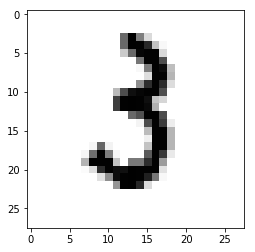

In [5]:
row_num = 1234
print(ytrain[row_num])
plt.imshow(xtrain[row_num], cmap = "gray_r")

Normalize the data. Each training element will be between 0 and 1. The test sample is normalized based on the training sample statistics.

In [6]:
xtrain = (xtrain - xtrain.min()) / (xtrain.max() - xtrain.min())
xtest = (xtest - xtrain.min()) / (xtrain.max() - xtrain.min())

## Model 1 - Single Layer Softmax

Many models begin by flattening the input: The 28x28 matrix is converted to a vector of length 784. 

Every model will end by softmax: The probabilities of image belonging to each class.

In model 1, this is all that we do.

In [8]:
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape = (28,28)),
    keras.layers.Dense(10, activation = tf.nn.softmax)
])

Keras models require a compile step to specify optimization method, loss function, etc.

In [9]:
model1.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

Keras lets us choose our batch size and number of epochs.

In [13]:
model1.fit(xtrain, ytrain, validation_split=.1, batch_size=64, epochs=5)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 2s 43us/sample - loss: 0.2464 - acc: 0.9315 - val_loss: 0.2219 - val_acc: 0.9413
Epoch 2/5
54000/54000 [==============================] - 2s 45us/sample - loss: 0.2456 - acc: 0.9316 - val_loss: 0.2212 - val_acc: 0.9393
Epoch 3/5
54000/54000 [==============================] - 2s 45us/sample - loss: 0.2445 - acc: 0.9313 - val_loss: 0.2238 - val_acc: 0.9388
Epoch 4/5
54000/54000 [==============================] - 2s 45us/sample - loss: 0.2441 - acc: 0.9329 - val_loss: 0.2238 - val_acc: 0.9398
Epoch 5/5
54000/54000 [==============================] - 2s 45us/sample - loss: 0.2432 - acc: 0.9321 - val_loss: 0.2217 - val_acc: 0.9393


Now we can evaluate the fit on our test sample.

In [14]:
test_loss1, test_acc1 = model1.evaluate(xtest, ytest)
print("Loss: ", test_loss1)
print("Acc: ", test_acc1)

10000/10000 [==============================] - 0s 32us/sample - loss: 1.7868 - acc: 0.8874
Loss:  1.786772271788078
Acc:  0.8874


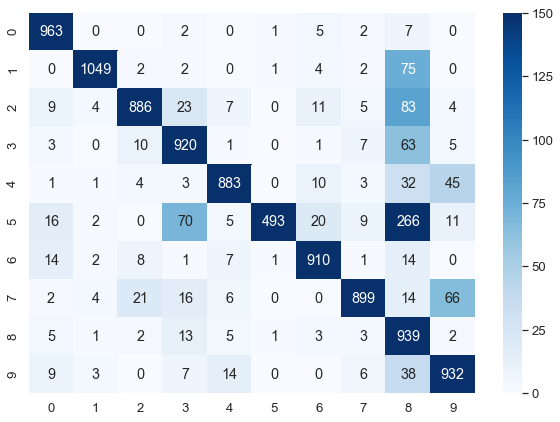

In [15]:
ypred1 = model1.predict_classes(xtest)
cm1 = metrics.confusion_matrix(ytest, ypred1)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.2)
sn.heatmap(cm1, annot = True, fmt = 'd', cmap = "Blues", vmax = 150)

For this simple model,we can plot the weights for each class.

In [16]:
m1wts = model1.get_weights()

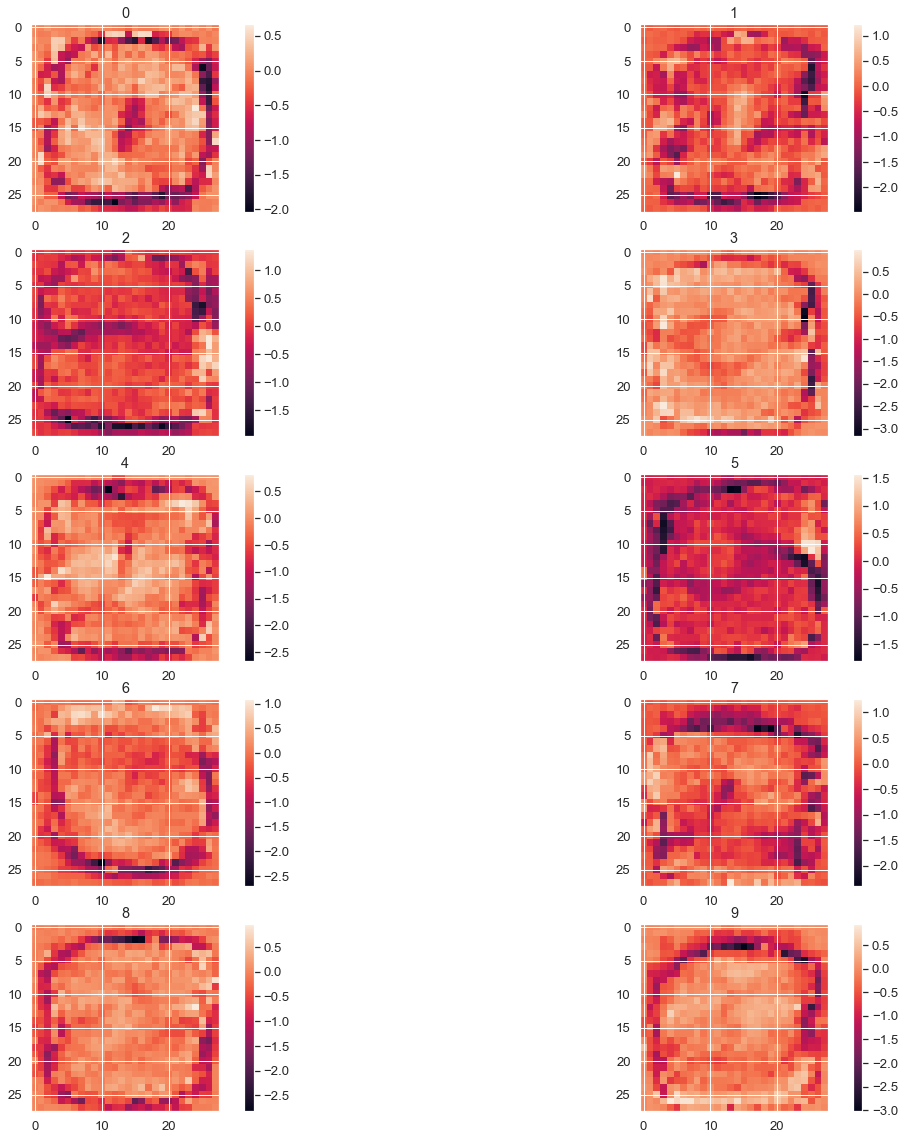

In [17]:
plt.figure(figsize = (20,20))
for i in range(0,10):
    plt.subplot(5,2,i+1).title.set_text(i)
    plt.imshow(m1wts[0][:,i].reshape(28,28))
    plt.colorbar()

## Model 2 - ReLu Hidden Layer

In model 2, we introduce a ReLu hidden layer.

In [19]:
model2 = keras.Sequential([
    keras.layers.Flatten(input_shape = (28,28)),
    keras.layers.Dense(500, activation = tf.nn.relu),
    keras.layers.Dense(10, activation = tf.nn.softmax)
])

model2.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

model2.fit(xtrain, ytrain, validation_split=.1, batch_size=64, epochs=5)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 3s 56us/sample - loss: 0.2419 - acc: 0.9302 - val_loss: 0.1098 - val_acc: 0.9712
Epoch 2/5
54000/54000 [==============================] - 3s 57us/sample - loss: 0.0969 - acc: 0.9714 - val_loss: 0.0822 - val_acc: 0.9758
Epoch 3/5
54000/54000 [==============================] - 3s 56us/sample - loss: 0.0621 - acc: 0.9815 - val_loss: 0.0788 - val_acc: 0.9778
Epoch 4/5
54000/54000 [==============================] - 3s 54us/sample - loss: 0.0430 - acc: 0.9871 - val_loss: 0.0682 - val_acc: 0.9797
Epoch 5/5
54000/54000 [==============================] - 3s 54us/sample - loss: 0.0317 - acc: 0.9905 - val_loss: 0.0625 - val_acc: 0.9818


In [20]:
test_loss2, test_acc2 = model2.evaluate(xtest, ytest)
print("Loss: ", test_loss2)
print("Acc: ", test_acc2)

10000/10000 [==============================] - 0s 34us/sample - loss: 0.2974 - acc: 0.9814
Loss:  0.29737027695902724
Acc:  0.9814


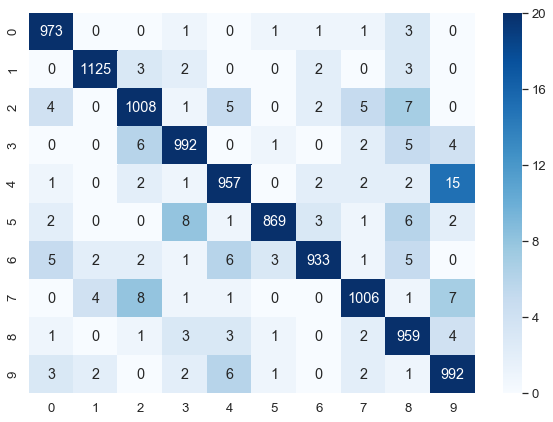

In [21]:
ypred2 = model2.predict_classes(xtest)
cm2 = metrics.confusion_matrix(ytest, ypred2)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.2)
sn.heatmap(cm2, annot = True, fmt = 'd', cmap = "Blues", vmax = 20)

## Model 3 - ReLu Hidden Layers

For model 3, lets add another ReLu layer.

In [22]:
model3 = keras.Sequential([
    keras.layers.Flatten(input_shape = (28,28)),
    keras.layers.Dense(500, activation = tf.nn.relu),
    keras.layers.Dense(500, activation = tf.nn.relu),
    keras.layers.Dense(10, activation = tf.nn.softmax)
])

model3.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

model3.fit(xtrain, ytrain, validation_split=0.1,batch_size=64, epochs=5)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 4s 68us/sample - loss: 0.2061 - acc: 0.9371 - val_loss: 0.0988 - val_acc: 0.9687
Epoch 2/5
54000/54000 [==============================] - 3s 62us/sample - loss: 0.0808 - acc: 0.9745 - val_loss: 0.0822 - val_acc: 0.9763
Epoch 3/5
54000/54000 [==============================] - 3s 62us/sample - loss: 0.0547 - acc: 0.9822 - val_loss: 0.0739 - val_acc: 0.9800
Epoch 4/5
54000/54000 [==============================] - 3s 63us/sample - loss: 0.0386 - acc: 0.9878 - val_loss: 0.0906 - val_acc: 0.9748
Epoch 5/5
54000/54000 [==============================] - 3s 63us/sample - loss: 0.0313 - acc: 0.9899 - val_loss: 0.0750 - val_acc: 0.9787


In [23]:
test_loss3, test_acc3 = model3.evaluate(xtest, ytest)
print("Loss: ", test_loss3)
print("Acc: ", test_acc3)

10000/10000 [==============================] - 0s 39us/sample - loss: 0.3025 - acc: 0.9811
Loss:  0.302508002456752
Acc:  0.9811


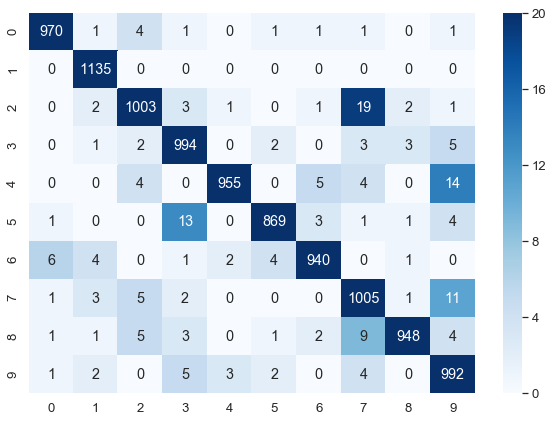

In [24]:
ypred3 = model3.predict_classes(xtest)
cm3 = metrics.confusion_matrix(ytest, ypred3)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.2)
sn.heatmap(cm3, annot = True, fmt = 'd', cmap = "Blues", vmax = 20)

## Model 4 - CNN

In [52]:
model4 = keras.Sequential([
    keras.layers.Conv2D(64, kernel_size=3, activation=tf.nn.relu, input_shape=(28,28,1)),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, kernel_size=3, activation=tf.nn.relu),
    keras.layers.Flatten(),
    keras.layers.Dense(500, activation = tf.nn.relu),
    keras.layers.Dense(10, activation = tf.nn.softmax)
])

model4.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

model4.fit(xtrain.reshape(60000,28,28,1), ytrain, validation_split=0.1, batch_size=64, epochs=5)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 5s 95us/sample - loss: 0.1314 - acc: 0.9605 - val_loss: 0.0420 - val_acc: 0.9872
Epoch 2/5
54000/54000 [==============================] - 5s 90us/sample - loss: 0.0403 - acc: 0.9868 - val_loss: 0.0380 - val_acc: 0.9878
Epoch 3/5
54000/54000 [==============================] - 5s 90us/sample - loss: 0.0261 - acc: 0.9920 - val_loss: 0.0347 - val_acc: 0.9908
Epoch 4/5
54000/54000 [==============================] - 5s 91us/sample - loss: 0.0167 - acc: 0.9945 - val_loss: 0.0360 - val_acc: 0.9903
Epoch 5/5
54000/54000 [==============================] - 5s 91us/sample - loss: 0.0123 - acc: 0.9960 - val_loss: 0.0464 - val_acc: 0.9892


In [55]:
test_loss4, test_acc4 = model4.evaluate(xtest.reshape(10000,28,28,1), ytest)
print("Loss: ", test_loss4)
print("Acc: ", test_acc4)

10000/10000 [==============================] - 1s 63us/sample - loss: 0.1931 - acc: 0.9879
Loss:  0.19306010757652767
Acc:  0.9879


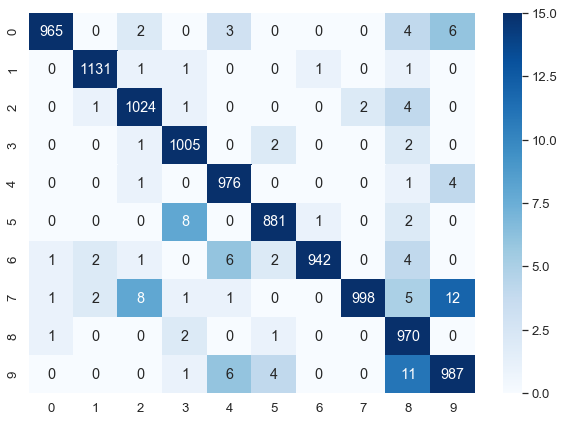

In [56]:
ypred4 = model4.predict_classes(xtest.reshape(10000,28,28,1))
cm4 = metrics.confusion_matrix(ytest, ypred4)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.2)
sn.heatmap(cm4, annot = True, fmt = 'd', cmap = "Blues", vmax = 15)

In [57]:
print(test_acc1)
print(test_acc2)
print(test_acc3)
print(test_acc4)

0.8874
0.9814
0.9811
0.9879


In [58]:
np.where((ypred4 == ytest) == False)

(array([ 247,  340,  359,  448,  619,  625,  659,  720,  726,  740,  813,
         846,  938, 1014, 1039, 1114, 1182, 1226, 1232, 1242, 1247, 1260,
        1319, 1328, 1393, 1459, 1522, 1554, 1570, 1709, 1721, 1790, 1808,
        1878, 1901, 1987, 2018, 2035, 2070, 2118, 2129, 2130, 2135, 2182,
        2185, 2293, 2414, 2597, 2654, 2713, 2896, 2915, 2921, 2939, 2995,
        3225, 3251, 3333, 3451, 3520, 3534, 3550, 3558, 3730, 3762, 3778,
        3808, 3926, 4007, 4065, 4078, 4176, 4199, 4238, 4360, 4369, 4504,
        4571, 4578, 4620, 4739, 4740, 4761, 4823, 4966, 5199, 5201, 5228,
        5246, 5265, 5268, 5331, 5600, 5634, 5654, 5655, 5887, 5937, 5955,
        5982, 6091, 6172, 6400, 6576, 6597, 6651, 6847, 6971, 7991, 8094,
        8273, 8316, 8519, 9009, 9158, 9505, 9530, 9664, 9729, 9755, 9850],
       dtype=int64),)

4
2


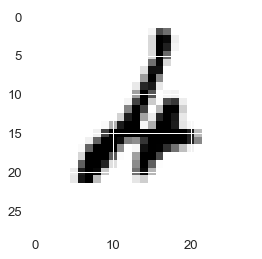

In [59]:
row_num = 247
print(ytest[row_num])
print(ypred4[row_num])
plt.imshow(xtest[row_num], cmap = "gray_r")

5
3


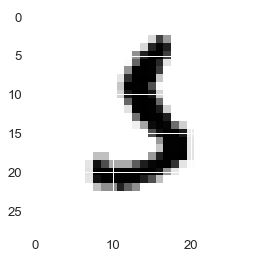

In [60]:
row_num = 340
print(ytest[row_num])
print(ypred4[row_num])
plt.imshow(xtest[row_num], cmap = "gray_r")